## Exploratory Plots of Digg Data

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# load in data
# votes = np.load("digg_votes.npy")
# friends = np.load("digg_friends.npy")

In [2]:
# extract all network information (compact dataframe of who is friends with whom)
# from https://github.com/geopanag/IMINFECTOR/blob/master/digg_preprocessing.py
def extract_network(file):
    friends = pd.read_csv(file,header=None)
    
    #--------- Remove self friendships
    friends = friends[friends[2]!=friends[3]]
    
    #--------- Repeat the reciprocal edges and append them
    reciprocal = friends[friends[0]==1]
    friends = friends.drop(0,1)
    reciprocal = reciprocal.drop(0,1)
    
    #---- Create the reciprocal edge for each pair
    tmp = reciprocal[2].copy()
    reciprocal[2] = reciprocal[3]
    reciprocal[3] = tmp

    #--------- Find the edges that already exist in the dataset as reciprocal, and remove them, 
    #--------- to avoid overwriting the currect time of the reciprocal edges that already exist
    to_remove = reciprocal.reset_index().merge(friends,left_on=[2,3],right_on=[2,3]).set_index('index').index
    reciprocal = reciprocal.drop(to_remove)
    
    friends = friends.append(reciprocal)
    friends[friends.duplicated([2,3],keep=False)] #-- this should be empty

    #----------- Store the weighted follow network
    friends.columns = ["time","a","b"]
    friends = friends[["a","b","time"]]
    return friends
#     friends.to_csv("../digg_network.txt",index=False,sep=" ",header=False)


# def extract_cascades(file):
#     #----------- Derive and store the train and test cascades
#     votes = pd.read_csv(file,header=None)
#     votes.columns = ["time","user","post"]
#     votes = votes.sort_values(by=["time"])
    
#     #---- Find the threshold after which the cascades are test cascades (final 20% of cascades)
#     start_times = votes.groupby("post")["time"].min() #--- take into consideration only the starting time of each cascade
#     start_times = start_times.sort_values()
#     no_test_cascades = round(20*len(start_times)/100)
#     threshold = min(start_times.tail(no_test_cascades))
#     #sum(start_times<threshold )/start_times.shape[0]
    
#     f_train = open("train_cascades.txt","w")
#     f_test = open("test_cascades.txt","w")

#     #--------- For each cascade
#     for i in votes["post"].unique():
#         print(i)
#         sub = votes[votes["post"]==i]
#         s = ""
    
#         #---- id:time, id:time etc...
#         for post in sub.sort_values(by=['time']).iterrows():
#             s = s+str(post[1]["user"])+" "+str(post[1]["time"])+";"#":"+str(post[1]["time"])+","
#         s = s[:-1]
    
#         #---- Check if it has started before or after the threshold
#         if(min(sub["time"])<threshold):
#             f_train.write(s+"\n")
#         else:
#             f_test.write(s+"\n")
#     f_train.close()
#     f_test.close()

In [3]:
file_friends = "digg2009/digg_friends.csv"
file_votes = "digg2009/digg_votes.csv"

friendships_df = extract_network(file_friends)
friendships_df = friendships_df.rename(columns={'a': 'source', 'b': 'target', 'time':'time'})

friendships_df.describe()
# friendships_df.to_csv("digg2009/digg_friends_preprocessed.csv", index=False)
# digg_extract_cascades(file_casc)

,source,target,time
count,2.251166e+06,2.251166e+06,2.251166e+06
mean,1.687565e+05,1.704176e+05,1.218754e+09
std,9.800988e+04,9.838381e+04,4.173192e+07
min,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.286500e+04,8.489300e+04,1.207766e+09
50%,1.675950e+05,1.698670e+05,1.223239e+09
75%,2.549290e+05,2.576040e+05,1.236996e+09
max,3.362250e+05,3.362250e+05,1.247033e+09


In [4]:
friendship_plot_df = friendships_df[['source', 'target']]
friendship_plot_smol = friendship_plot_df.head(150)
friendship_plot_smol.head()

,source,target
0,336224,266641
1,336224,215086
2,336224,151094
3,336224,59378
4,336224,8547


/Users/mdong/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


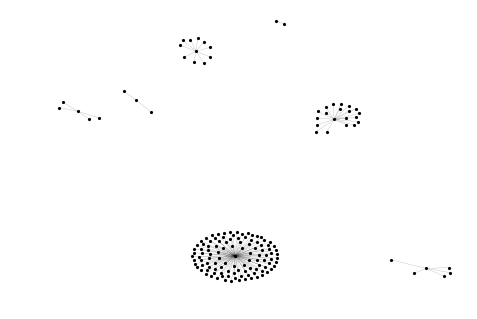

In [5]:
# plot of directed graph showing all friendships (currently taking a random sample due to size issues)
G = nx.convert_matrix.from_pandas_edgelist(friendship_plot_smol)
options = {
    "node_color": "black",
    "node_size": 10,
    "linewidths": 0,
    "width": 0.1,
}
nx.draw(G, **options)
plt.show()

###### currently, scability of networkx is an issue; look into https://graph-tool.skewed.de/ if we want to graph more points

## Plot of social network graph for one story

In [6]:
votes = pd.read_csv(file_votes,header=None)
votes.columns = ['time','user','post']
votes = votes.sort_values(by=["time"])
votes.describe()

,time,user,post
count,3.018197e+06,3.018197e+06,3.018197e+06
mean,1.245300e+09,1.662883e+05,1.767381e+03
std,7.750953e+05,9.842756e+04,1.012042e+03
min,1.243770e+09,2.000000e+00,1.000000e+00
25%,1.244635e+09,7.905100e+04,8.560000e+02
50%,1.245307e+09,1.660930e+05,1.774000e+03
75%,1.245961e+09,2.515810e+05,2.666000e+03
max,1.246793e+09,3.362240e+05,3.553000e+03


In [7]:
# the most popular story is story xxx?
story = 17

votes_story = votes.loc[votes['post'] == story]
votes_story = votes_story.drop(['post'], axis=1)
votes_source = votes_story.iloc[0]['user']
tmp = votes_story.copy()
votes_story.describe()

,time,user
count,3.530000e+02,353.000000
mean,1.246574e+09,164842.954674
std,3.345080e+04,99752.800587
min,1.246542e+09,736.000000
25%,1.246560e+09,70227.000000
50%,1.246563e+09,165027.000000
75%,1.246574e+09,251140.000000
max,1.246761e+09,336001.000000


In [8]:
# cross join to get all edges in network graph
votes_story['key'] = 0
tmp['key'] = 0
merged = votes_story.merge(tmp, how='outer', on='key')
merged = merged.drop(columns=['key'])
merged = merged.loc[merged['time_x'] < merged['time_y']]
merged = merged.drop(['time_x', 'time_y'], axis=1)
merged.columns = ['source', 'target']
merged.head()
# merged.describe()

,source,target
1,90015,219516
2,90015,334285
3,90015,7784
4,90015,33633
5,90015,308834


In [9]:
# keep rows that are in friends_preprocessed df
merged_plot = friendship_plot_df.merge(merged, on=['source', 'target'], how='inner')
merged_plot.head()

,source,target
0,336001,268747
1,336001,250189
2,336001,144354
3,336001,132423
4,336001,75729


In [10]:
# define edges of social network graph by adding entries of adjacent users
# votes_story = pd.concat([votes_story, votes_story[['user']].shift(-1)], axis=1, ignore_index=True)
# votes_story.drop(votes_story.tail(1).index,inplace=True)
# votes_story.columns = ['source', 'target']
# votes_story.head()

/Users/mdong/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


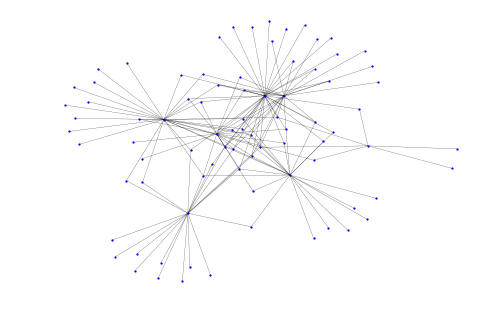

In [11]:
# plot social network graph for one story
G = nx.convert_matrix.from_pandas_edgelist(merged_plot.head(150))
position = nx.circular_layout(G)
options = {
    "node_color": "b",
    "node_size": 5,
    "linewidths": 0,
    "width": 0.2,
}
# nx.draw_networkx_nodes(G, position, nodelist=[votes_source], node_color="r")
nx.draw(G, **options)
# plt.show()

## Distance Calculations

In [12]:
friendship_plot_df.head()

,source,target
0,336224,266641
1,336224,215086
2,336224,151094
3,336224,59378
4,336224,8547


In [163]:
# the most popular story is story xxx?
story = 1

votes_story = votes.loc[votes['post'] == story]
votes_714 = votes_story.copy()

# define source
source = votes_story.iloc[0]['user']
votes_story = votes_story.iloc[1:]  # drop source
print(source)
votes_story.head()

199749


,time,user,post
158,1246563235,87621,1
538,1246563451,308947,1
551,1246563518,314417,1
220,1246563674,126941,1
119,1246563674,65398,1


In [164]:
friends_of_source = friendship_plot_df.loc[friendship_plot_df['target'] == source]
friends_of_source = friends_of_source['source'].tolist()
# friends_of_source.describe()

In [165]:
# find distance 1 voters
dist_1_users = votes_story.loc[votes_story['user'].isin(friends_of_source)]
dist_1_users = dist_1_users['user'].tolist()

votes_story = votes_story.loc[~votes_story['user'].isin(dist_1_users)]
votes_story.head()

,time,user,post
220,1246563674,126941,1
522,1246563836,299620,1
508,1246563862,291850,1
511,1246564109,292249,1
318,1246564437,176328,1


In [166]:
# all friend at distance 2 (regardless of whether they voted)
dist_2_friends = []
friends = friendship_plot_df.loc[friendship_plot_df['target'].isin(friends_of_source)]
dist_2_friends = friends['source'].tolist()

# find distance 2 voters
dist_2_users = votes_story.loc[votes_story['user'].isin(dist_2_friends)]
dist_2_users = dist_2_users['user'].tolist()
votes_story = votes_story.loc[~votes_story['user'].isin(dist_2_users)]
# dist_2_users

In [167]:
# all friend at distance 3 (regardless of whether they voted)
dist_3_friends = []
friends = friendship_plot_df.loc[friendship_plot_df['target'].isin(dist_2_friends)]
dist_3_friends = friends['source'].tolist()

# find distance 3 voters
dist_3_users = votes_story.loc[votes_story['user'].isin(dist_3_friends)]
dist_3_users = dist_3_users['user'].tolist()
votes_story = votes_story.loc[~votes_story['user'].isin(dist_3_users)]
# dist_3_users

In [168]:
# all friend at distance 4 (regardless of whether they voted)
dist_4_friends = []
friends = friendship_plot_df.loc[friendship_plot_df['target'].isin(dist_3_friends)]
dist_4_friends = friends['source'].tolist()

# find distance 4 voters
dist_4_users = votes_story.loc[votes_story['user'].isin(dist_4_friends)]
dist_4_users = dist_4_users['user'].tolist()
votes_story = votes_story.loc[~votes_story['user'].isin(dist_4_users)]
# dist_4_users

In [169]:
# all friend at distance 5 (regardless of whether they voted)
dist_5_friends = []
friends = friendship_plot_df.loc[friendship_plot_df['target'].isin(dist_4_friends)]
dist_5_friends = friends['source'].tolist()

# find distance 5 voters
dist_5_users = votes_story.loc[votes_story['user'].isin(dist_5_friends)]
dist_5_users = dist_5_users['user'].tolist()
votes_story = votes_story.loc[~votes_story['user'].isin(dist_5_users)]
# dist_5_users

In [170]:
# all friend at distance 6 (regardless of whether they voted)
dist_6_friends = []
friends = friendship_plot_df.loc[friendship_plot_df['target'].isin(dist_5_friends)]
dist_6_friends = friends['source'].tolist()

# find distance 6 voters
dist_6_users = votes_story.loc[votes_story['user'].isin(dist_6_friends)]
dist_6_users = dist_6_users['user'].tolist()
votes_story = votes_story.loc[~votes_story['user'].isin(dist_6_users)]
# dist_6_users

In [171]:
# all friend at distance 7 (regardless of whether they voted)
dist_7_friends = []
friends = friendship_plot_df.loc[friendship_plot_df['target'].isin(dist_6_friends)]
dist_7_friends = friends['source'].tolist()

# find distance 7 voters
dist_7_users = votes_story.loc[votes_story['user'].isin(dist_7_friends)]
dist_7_users = dist_7_users['user'].tolist()
votes_story = votes_story.loc[~votes_story['user'].isin(dist_7_users)]
# dist_7_users

In [172]:
# all friend at distance 8 (regardless of whether they voted)
dist_8_friends = []
friends = friendship_plot_df.loc[friendship_plot_df['target'].isin(dist_7_friends)]
dist_8_friends = friends['source'].tolist()

# find distance 8 voters
dist_8_users = votes_story.loc[votes_story['user'].isin(dist_8_friends)]
dist_8_users = dist_8_users['user'].tolist()
votes_story = votes_story.loc[~votes_story['user'].isin(dist_8_users)]
# dist_8_users

In [173]:
print(len(friends_of_source))
print(len(dist_2_friends))
print(len(dist_3_friends))
print(len(dist_4_friends))
print(len(dist_5_friends))
print(len(dist_6_friends))
print(len(dist_7_friends))
print(len(dist_8_friends))

1020
273388
1571443
1919342
1997461
2016886
2021359
2022396


In [174]:
all_friends = [259, 49014, 1126905, 2052095, 2170024, 2194024, 2199247, 2200477]

In [175]:
# create new distance column
votes_714['dist'] = 100  # 100 is placeholder for anything greater than 5
votes_714.loc[votes_714['user'] == source, 'dist'] = 0
votes_714.loc[votes_714['user'].isin(dist_1_users), 'dist'] = 1
votes_714.loc[votes_714['user'].isin(dist_2_users), 'dist'] = 2
votes_714.loc[votes_714['user'].isin(dist_3_users), 'dist'] = 3
votes_714.loc[votes_714['user'].isin(dist_4_users), 'dist'] = 4
votes_714.loc[votes_714['user'].isin(dist_5_users), 'dist'] = 5
votes_714.loc[votes_714['user'].isin(dist_6_users), 'dist'] = 6
votes_714.loc[votes_714['user'].isin(dist_7_users), 'dist'] = 7
votes_714.loc[votes_714['user'].isin(dist_8_users), 'dist'] = 8

In [176]:
votes_714.to_csv("digg2009/votes_1.csv", index=False)
votes_714[['time', 'user', 'dist', 'post']].head(10)

,time,user,dist,post
358,1246563078,199749,0,1
158,1246563235,87621,1,1
538,1246563451,308947,1,1
551,1246563518,314417,1,1
220,1246563674,126941,100,1
119,1246563674,65398,1,1
30,1246563734,16255,1,1
522,1246563836,299620,2,1
508,1246563862,291850,2,1
244,1246563896,136919,1,1


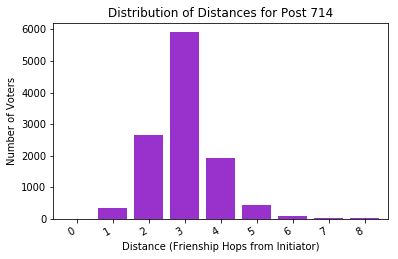

In [111]:
votes_hist = votes_714.loc[votes_714['dist'] <= 10]
vc = votes_hist.dist.value_counts().sort_index()
ax = vc.plot(kind='bar', color='darkorchid', width=0.8)
fig = ax.get_figure()
ax.set_xlabel('Distance (Frienship Hops from Initiator)')
ax.set_ylabel('Number of Voters')
ax.set_title('Distribution of Distances for Post 714')
fig.autofmt_xdate()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5011afda0>]],
      dtype=object)

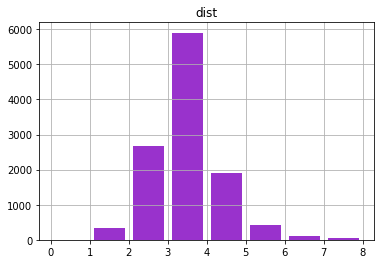

In [112]:
# plot distribution
votes_hist = votes_714.loc[votes_714['dist'] <= 10]
votes_hist.hist('dist', bins=8, color='darkorchid', rwidth=0.8)


In [114]:
# # cross join to get all edges in network graph
# votes_714['key'] = 0
# tmp = votes_714.copy()
# tmp['key'] = 0
# merged = votes_714.merge(tmp, how='outer', on='key')
# merged = merged.drop(columns=['key'])
# merged = merged.loc[merged['time_x'] < merged['time_y']]
# merged = merged.drop(['time_x', 'time_y'], axis=1)
# merged = merged[['user_x', 'user_y', 'dist_y']]
# merged.columns = ['source', 'target', 'dist']
# merged.head()
# # merged.describe()

# # keep rows that are in friends_preprocessed df
# merged_plot = friendship_plot_df.merge(merged, on=['source', 'target'], how='inner')
# merged_plot.head()

In [115]:
# dummy data, Graph and positions
G = nx.from_pandas_edgelist(merged_plot.head(150), source='source', target='target', edge_attr='dist')
pos = nx.spring_layout(G)

# extract the edge weight
edge_colors = [a['dist'] for u,v,a in G.edges(data=True)]

# draw nodes and edges separately. allows using colormap for edges.
nx.draw_networkx_nodes(G, pos=pos, with_labels=False, node_size=5, node_color="b")
nx.draw_networkx_edges(G, pos=pos, 
                       edge_color=edge_colors, 
                       edge_cmap=plt.cm.cool, 
                       edge_vmin=1, 
                       edge_vmax=np.max(edge_colors), 
                       width=1)

sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(vmin=1, vmax=np.max(edge_colors)))
sm.set_array([])
# plt.box(False)
plt.axis('off')
plt.colorbar(sm)
plt.show()

NetworkXError: Invalid edge_attr argument: dist

In [ ]:
# plot social network graph for one story
G = nx.convert_matrix.from_pandas_edgelist(merged_plot[['user_x', 'user_y']].head(150))
pos = nx.spring_layout(G)
options = {
    "node_color": "b",
    "node_size": 5,
    "linewidths": 0,
    "width": 0.2,
}

edge_colors = [merged_plot.iloc[merged_plot['target']==v]['dist'] for u,v,a in G.edges(data=True)]

# nx.draw_networkx_nodes(G, position, nodelist=[votes_source], node_color="r")
nx.draw(G, **options)
# plt.show()